In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from os import listdir
from os.path import isfile, join
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Input,Lambda
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from PIL import Image
import imutils
from tqdm import tqdm


In [6]:
def crop_img(img):
    # Find the extreme points and take a reactangle out of them
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # colored to grayscale image
    gray = cv2.GaussianBlur(gray, (3, 3), 0) # to reduce noise in the image

    # find contours in thresholded image, then grab the largest one
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres = cv2.erode(thres, None, iterations=2)
    thres = cv2.dilate(thres, None, iterations=2)
    # we usually want the focused part to be white for it to be detected correctly
    # Image contouring is process of identifying structural outlines of objects for better detection
    cntrs = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # image, contour retrieval method and contour approximation
    cntrs = imutils.grab_contours(cntrs) # actually obtain the contours
    c = max(cntrs, key=cv2.contourArea) # obtain the largest contour
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise

    # Now that we have obtained the largest contour of an image, we must determine the extreme points
    # find the extreme points

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # adding the contour on image
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

    # adding the extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # crop
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

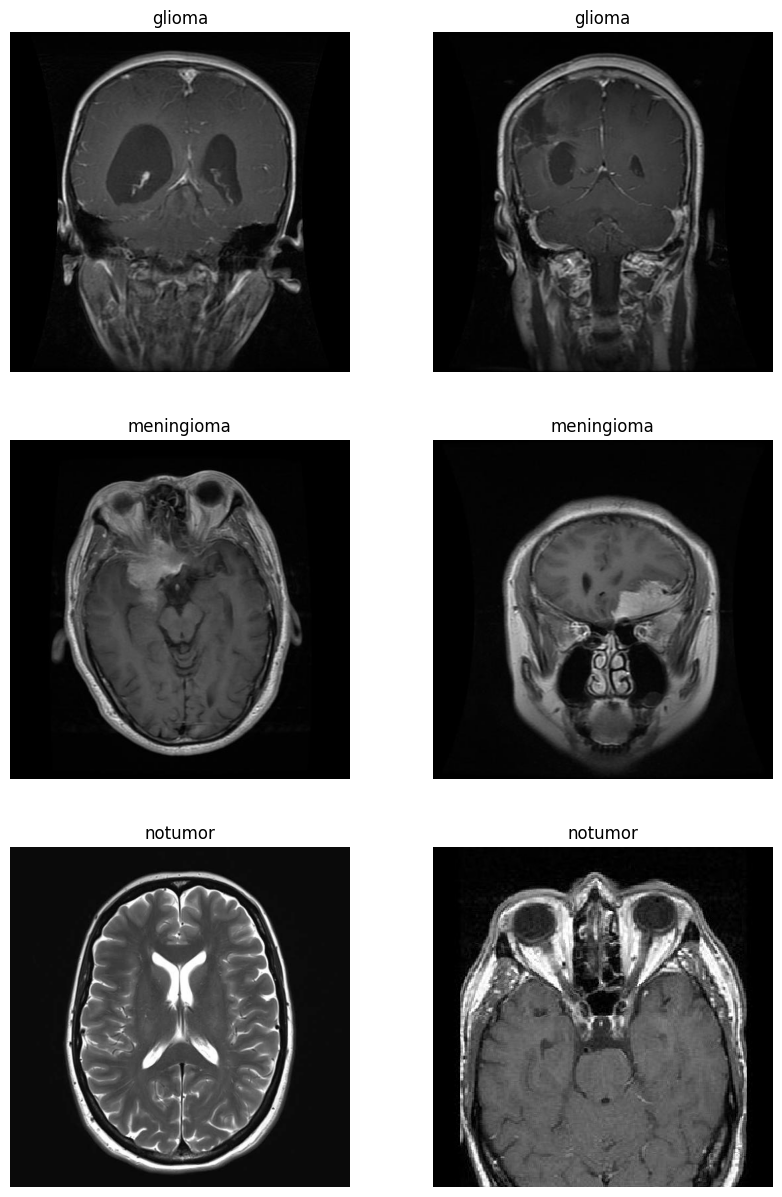

In [9]:

dirs=('/content/drive/MyDrive/MRI_tumor/Training')
categories=['glioma','glioma', 'meningioma', 'meningioma','notumor','notumor']
plt.figure(figsize=(10,15))
img_path=['/glioma/Tr-gl_0015.jpg', '/glioma/Tr-gl_0010.jpg', '/meningioma/Tr-meTr_0005.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0005.jpg', '/notumor/Tr-noTr_0000.jpg']

for i in range(0, 6):
    ax=plt.subplot(3, 2, i + 1)
    img=cv2.imread(dirs + img_path[i])
    new_img=crop_img(img)
    plt.imshow(img)
    plt.axis('off')
    plt.title(categories[i])

In [10]:
img = cv2.imread('/content/drive/MyDrive/MRI_tumor/Training/meningioma/Tr-meTr_0000.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

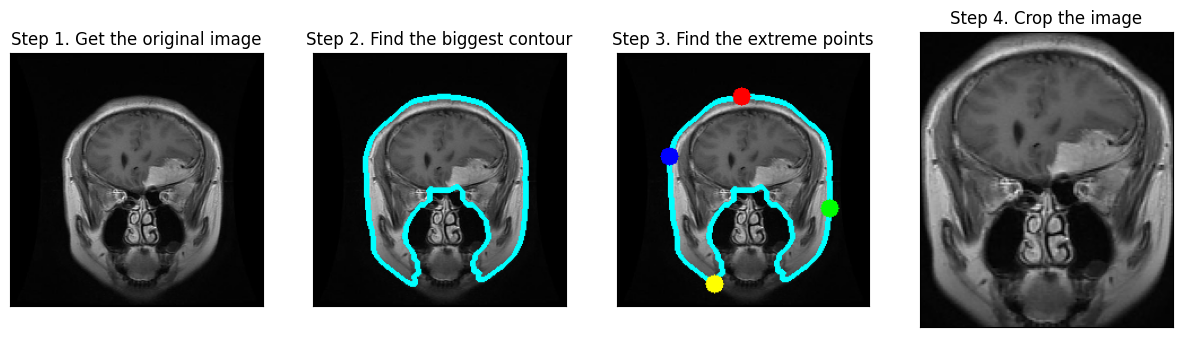

In [11]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [14]:
#Dont tun this code

training='/content/drive/MyDrive/MRI_tumor/Training/'

training_dir=os.listdir(training)

img_size=200

for dir in training_dir:
    save_path=training + '/cropped/' + dir
    path=os.path.join(training, dir)
    image_dir=os.listdir(path)
    for img in image_dir:
        image=cv2.imread(os.path.join(path, img))
        new_img=crop_img(image)
        new_img=cv2.resize(new_img, (img_size, img_size))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)



In [16]:
labels = ['glioma', 'meningioma', 'notumor']

x = [] # training images.
y  = [] # training labels.

image_size = 150


for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/MRI_tumor/Training/cropped', label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x.append(image)
        y.append(labels.index(label))

100%|██████████| 1595/1595 [00:21<00:00, 74.39it/s] 


In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, shuffle = True)

l = len(x_test)//2
x_valid, y_valid = x_test[:l], y_test[:l]
x_test, y_test = x_test[l:], y_test[l:]

In [18]:
x_train=np.array(x_train)
x_train = (x_train.astype('float32') )/ 255
x_test=np.array(x_test)
x_test = (x_test.astype('float32') )/ 255
x_valid=np.array(x_valid)
x_valid = (x_valid.astype('float32') )/ 255

y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(3404, 150, 150, 3)
(426, 150, 150, 3)
(425, 150, 150, 3)


4 type code start

In [20]:
resnet = ResNet50(
    input_shape = [150,150] + [3], # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
)

In [21]:
x = Flatten()(resnet.output)

In [22]:
prediction = Dense(3, activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [24]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [25]:
history=model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid),epochs = 100)

Epoch 1/100
107/107 [==============================] - 62s 224ms/step - loss: 2.1447 - accuracy: 0.7476 - val_loss: 12.7912 - val_accuracy: 0.2659
Epoch 2/100
107/107 [==============================] - 19s 179ms/step - loss: 1.0327 - accuracy: 0.8085 - val_loss: 3.6047 - val_accuracy: 0.2659
Epoch 3/100
107/107 [==============================] - 19s 180ms/step - loss: 0.8584 - accuracy: 0.8452 - val_loss: 8.3855 - val_accuracy: 0.2659
Epoch 4/100
107/107 [==============================] - 19s 181ms/step - loss: 0.6734 - accuracy: 0.8696 - val_loss: 1.0937 - val_accuracy: 0.3929
Epoch 5/100
107/107 [==============================] - 19s 177ms/step - loss: 0.6215 - accuracy: 0.8784 - val_loss: 1.5326 - val_accuracy: 0.2824
Epoch 6/100
107/107 [==============================] - 21s 196ms/step - loss: 0.3005 - accuracy: 0.9010 - val_loss: 4.3596 - val_accuracy: 0.2659
Epoch 7/100
107/107 [==============================] - 20s 187ms/step - loss: 0.3183 - accuracy: 0.9236 - val_loss: 1.5395 

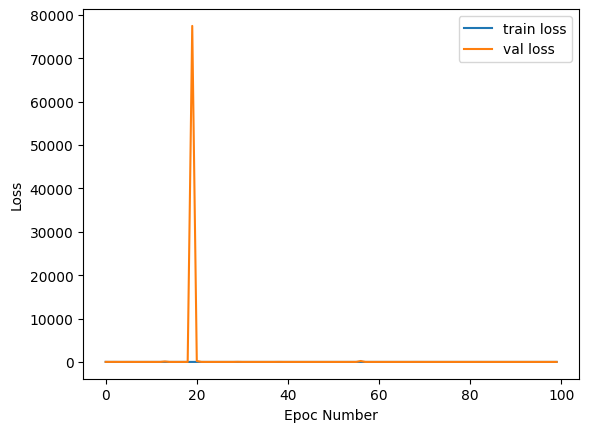

In [26]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoc Number')
plt.ylabel('Loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

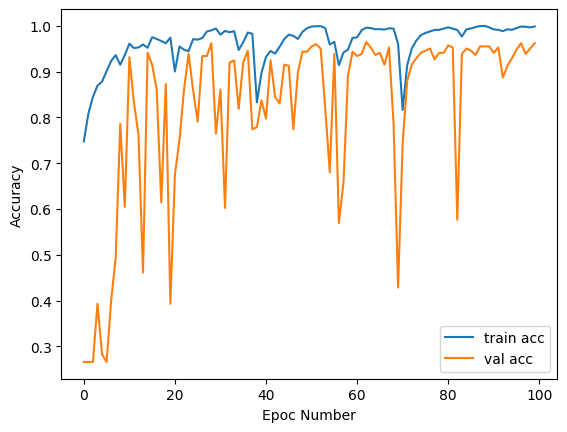

In [27]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoc Number')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [28]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])

# 0: test loss, 1: test accuracy


 Test accuracy: 0.9389671087265015


14/14 [==============================] - 2s 55ms/step
                       precision    recall  f1-score   support

    giloma (Class 0 )       0.98      0.89      0.93       142
muningioma (Classs 1)       0.86      0.98      0.92       124
   no tumor (class 1)       0.97      0.96      0.97       160

             accuracy                           0.94       426
            macro avg       0.94      0.94      0.94       426
         weighted avg       0.94      0.94      0.94       426



Text(50.722222222222214, 0.5, 'Actual values')

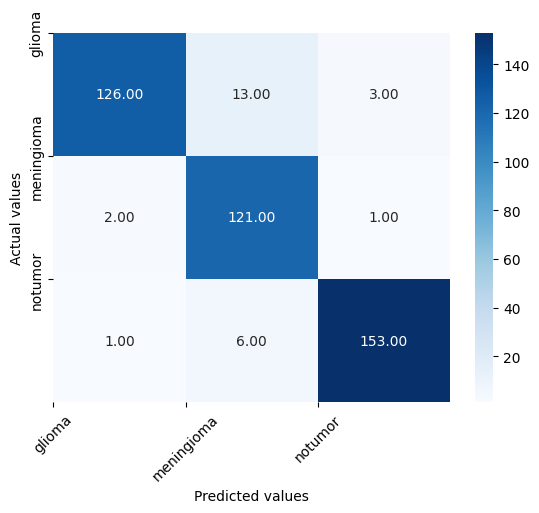

In [29]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np
#predict
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test,target_names=['giloma (Class 0 )','muningioma (Classs 1)','no tumor (class 1)']))
cm=confusion_matrix(y_pred,y_test)
sns.heatmap(cm,annot=True,cmap=plt.cm.Blues,fmt='.2f',)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
